### Step 1. 讀資料進來

In [1]:
import pandas as pd
import re

In [2]:
data = pd.read_csv("features.csv")

In [4]:
stopword = open("Chinese_stopwords.txt").read()

In [5]:
clean_token = []
for i in data["tokens"]:
    token_list = i.split(" ")
    clean = ""
    for token in token_list:
        if token not in stopword:
            clean = clean+" "+token
    clean_token.append(clean)

In [6]:
data["clean"] = clean_token

### TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer() #初始化工具
vectorized_data = vectorizer.fit_transform(data["clean"])

In [9]:
tfidf_arr = vectorizer.get_feature_names_out() # 取出每一個被計算的詞
tfidf_data = vectorizer.transform(data["clean"]) 
annotation = tfidf_data.toarray()

In [10]:
tfidf = pd.DataFrame(annotation, columns=[tfidf_arr])

In [11]:
feature = data[["adverb", "first_personal", "reporting_verbs", "ner", "positive", "negative", "neutral", "aspect_markers"]]

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8289 entries, 0 to 8288
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             8289 non-null   object 
 1   label            8289 non-null   float64
 2   adverb           8289 non-null   float64
 3   first_personal   8289 non-null   float64
 4   reporting_verbs  8289 non-null   float64
 5   ner              8289 non-null   float64
 6   sentiment        8289 non-null   int64  
 7   tokens           8289 non-null   object 
 8   tags             8289 non-null   object 
 9   positive         8289 non-null   int64  
 10  negative         8289 non-null   int64  
 11  neutral          8289 non-null   float64
 12  senti_score      8289 non-null   float64
 13  clean            8289 non-null   object 
 14  aspect_markers   8289 non-null   float64
dtypes: float64(8), int64(3), object(4)
memory usage: 1.3+ MB


In [13]:
tf_feature = pd.concat([feature, tfidf], axis=1)

### 分離特徵跟答案

In [14]:
# 答案
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label = data[["label"]].apply(LabelEncoder().fit_transform)

### 區分訓練集跟測試集

In [15]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority', random_state = 168)
feature_undersampled, label_undersampled = undersample.fit_resample(tf_feature, label)

e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [16]:
import imblearn
print(imblearn.__version__)

0.10.1


In [17]:
from sklearn.model_selection import train_test_split
feature_train, feature_test, label_train, label_test = train_test_split(feature_undersampled, label_undersampled, test_size = 0.2, random_state = 168)

In [18]:
column_name = list(tf_feature.columns)

In [19]:
new = []
for name in column_name:
    string = str(name)
    new_name = re.sub(r"\(|\)|,|'", "", string)
    new.append(new_name)

### 模型訓練

#### Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB_model = NB.fit(feature_train, label_train)

e:\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


#### Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier
DT_gini = DecisionTreeClassifier(criterion = "gini", random_state = 143)
DT_gini_model = DT_gini.fit(feature_train, label_train)

e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [22]:
DT_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 143)
DT_entropy_model = DT_entropy.fit(feature_train, label_train)

e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


#### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

RF_gini = RandomForestClassifier(criterion = "gini", random_state = 143)
RF_gini_model = RF_gini.fit(feature_train, label_train)

e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_7228\424854700.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_gini_model = RF_gini.fit(feature_train, label_train)


In [24]:
RF_entropy = RandomForestClassifier(criterion = "entropy", random_state = 143)
RF_entropy_model = RF_entropy.fit(feature_train, label_train)

e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_7228\3780857554.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_entropy_model = RF_entropy.fit(feature_train, label_train)


#### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR_model = LR.fit(feature_train, label_train)

e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
e:\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### SVM

In [26]:
from sklearn.svm import LinearSVC
SVM_linear = LinearSVC(random_state=168, tol=1e-5)
SVM_linear_model = SVM_linear.fit(feature_train, label_train)

e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
e:\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8289 entries, 0 to 8288
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   8289 non-null   int64
dtypes: int64(1)
memory usage: 387.6 KB


### 預測

In [28]:
NB_prediction = NB_model.predict(feature_test)
DT_gini_prediction = DT_gini_model.predict(feature_test)
DT_entropy_prediction = DT_entropy_model.predict(feature_test)
RF_gini_prediction = RF_gini_model.predict(feature_test)
RF_entropy_prediction = RF_entropy_model.predict(feature_test)
LR_prediction = LR_model.predict(feature_test)
SVM_linear_prediction = SVM_linear_model.predict(feature_test)

e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
e:\Python\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Fea

### 評估結果

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score

def model_metrics(prediction, label): 
    
    print(ConfusionMatrixDisplay.from_predictions(label, prediction, cmap = "Wistia")) 
    evaluation = precision_recall_fscore_support(label, prediction, average='macro') 
    accuracy = accuracy_score(label, prediction) # 計算accuracy

    print("accuracy: " + str(round(accuracy, 2)) + "\nprecision: " + str(round(evaluation[0], 2)) + "\nrecall: " + str(round(evaluation[1], 2)) + "\nfscore: " + str(round(evaluation[2],2)))

#### Naive Bayes

accuracy: 0.67
precision: 0.67
recall: 0.66
fscore: 0.66


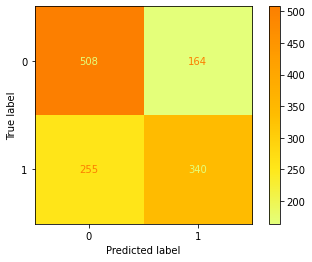

In [30]:
model_metrics(NB_prediction, label_test)

#### Decision Tree

accuracy: 0.64
precision: 0.64
recall: 0.63
fscore: 0.63


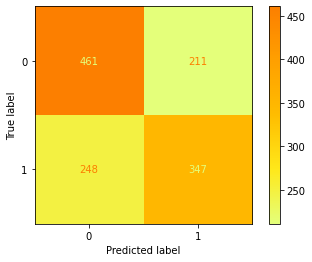

In [31]:
model_metrics(DT_gini_prediction, label_test)

accuracy: 0.64
precision: 0.64
recall: 0.64
fscore: 0.64


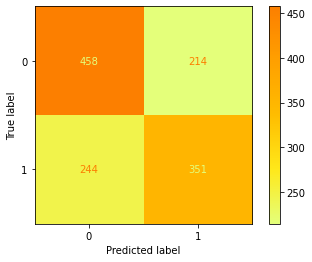

In [32]:
model_metrics(DT_entropy_prediction, label_test)

#### Random Forest

accuracy: 0.7
precision: 0.7
recall: 0.7
fscore: 0.7


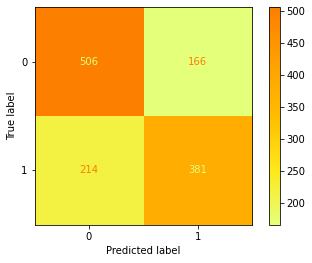

In [33]:
model_metrics(RF_gini_prediction, label_test)

accuracy: 0.71
precision: 0.71
recall: 0.71
fscore: 0.71


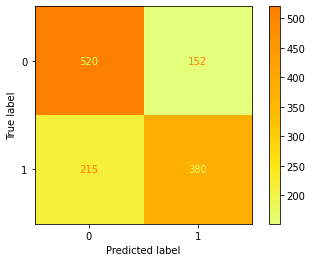

In [34]:
model_metrics(RF_entropy_prediction, label_test)

#### Logistic Regression

accuracy: 0.74
precision: 0.74
recall: 0.74
fscore: 0.74


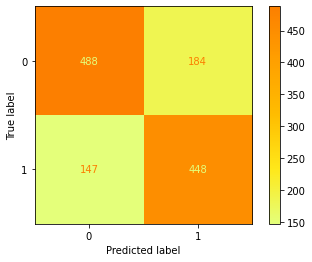

In [35]:
model_metrics(LR_prediction, label_test)

#### SVM

accuracy: 0.74
precision: 0.74
recall: 0.74
fscore: 0.74


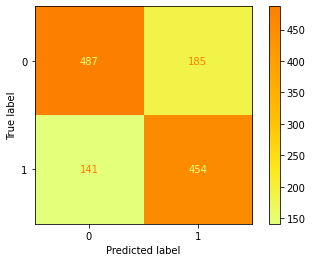

In [36]:
model_metrics(SVM_linear_prediction, label_test)

In [37]:
LR_model.coef_[0][0:8]

array([-0.46644933, -0.61582239,  0.08420307,  0.3759675 , -0.09666876,
        0.31210809, -0.11429395,  0.46798248])

In [38]:
SVM_linear_model.coef_[0][0:8]

array([-0.12452032, -0.18893277,  0.05231698,  0.18221215, -0.02215651,
        0.12487354, -0.04238845,  0.18258612])

In [39]:
DT_entropy_model.feature_importances_[0:8]

array([0.01380168, 0.01227048, 0.00868539, 0.00983384, 0.010652  ,
       0.01581119, 0.00143219, 0.01087533])

In [40]:
DT_gini_model.feature_importances_[0:8]

array([0.01866396, 0.01174244, 0.00553356, 0.00796973, 0.00616132,
       0.01918445, 0.00344915, 0.00991058])

In [41]:
RF_entropy_model.feature_importances_[0:8]

array([0.00865006, 0.00690609, 0.0039543 , 0.00663975, 0.00629266,
       0.0099264 , 0.00346706, 0.00771961])

In [42]:
RF_gini_model.feature_importances_[0:8]

array([0.01001381, 0.00893779, 0.00394973, 0.00711807, 0.00602714,
       0.01072738, 0.00382001, 0.00921685])

In [43]:
feature

,adverb,first_personal,reporting_verbs,ner,positive,negative,neutral,aspect_markers
0,1.0,1.0,1.0,1.0,0,0,1.0,0.1
1,0.1,1.0,1.0,1.0,0,1,0.1,1.0
2,0.1,0.1,0.1,0.1,0,0,1.0,0.1
3,0.1,0.1,0.1,0.1,0,0,1.0,1.0
4,0.1,0.1,0.1,0.1,0,0,1.0,0.1
...,...,...,...,...,...,...,...,...
8284,1.0,1.0,1.0,0.1,0,0,1.0,0.1
8285,0.1,0.1,0.1,0.1,0,0,1.0,0.1
8286,0.1,1.0,0.1,1.0,0,0,1.0,1.0
8287,0.1,0.1,1.0,0.1,0,0,1.0,0.1


In [44]:
LR_importance = pd.DataFrame(LR_model.coef_, columns = tf_feature.columns).T

In [45]:
LR_importance.columns = ["importance"]

In [46]:
LR_importance.sort_values(by=["importance"])

,importance
"(電影,)",-3.545060
"(劇情,)",-2.513678
"(導演,)",-2.290887
"(故事,)",-2.017898
"(角色,)",-1.981232
...,...
"(阿綸,)",1.948085
"(最後,)",2.052622
"(小咪,)",2.129842
"(保羅,)",2.155462


In [47]:
SVM_importance = pd.DataFrame(SVM_linear_model.coef_, columns = tf_feature.columns).T
SVM_importance.columns = ["importance"]
SVM_importance.sort_values(by=["importance"]).tail(10)

,importance
"(老爸,)",1.424272
"(黛安娜,)",1.429644
"(保羅,)",1.445564
"(jacques,)",1.487361
"(小咪,)",1.501441
"(淑子,)",1.589775
"(廣告,)",1.595434
"(人類,)",1.606262
"(兒子,)",1.617791
"(無法,)",1.667580


In [48]:
SVM_importance.sort_values(by=["importance"]).head(10)

,importance
"(作品,)",-1.658680
"(演員,)",-1.574521
"(電影,)",-1.553538
"(感受到,)",-1.549314
"(漫威,)",-1.476158
"(強調,)",-1.430244
"(隊長,)",-1.390940
"(顯示出,)",-1.388329
"(期待,)",-1.386640
"(偶然,)",-1.353176


In [49]:
LR_importance.sort_values(by=["importance"]).head(10)

,importance
"(電影,)",-3.545060
"(劇情,)",-2.513678
"(導演,)",-2.290887
"(故事,)",-2.017898
"(角色,)",-1.981232
"(作品,)",-1.943276
"(演員,)",-1.918767
"(期待,)",-1.895603
"(觀眾,)",-1.864449
"(特效,)",-1.823472


In [50]:
LR_importance.sort_values(by=["importance"]).tail(10)

,importance
"(殺手,)",1.578398
"(女兒,)",1.670407
"(無法,)",1.682653
"(媽媽,)",1.723733
"(老爸,)",1.911899
"(阿綸,)",1.948085
"(最後,)",2.052622
"(小咪,)",2.129842
"(保羅,)",2.155462
"(兒子,)",2.267329
